# Open exploration
Exploring 1000 scenarios over the whole uncertainty space with lhs. 60 replications are used. This notebook includes the following:

- Fitting a linear regression model
- Feature scoring using the extra trees algorithm
- Visual analysis using plotting
- Scenario discovery using PRIM

In [1]:
from ema_workbench.analysis import prim
from ema_workbench import load_results, save_results, ema_logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

<frozen importlib._bootstrap>:914: ImportWarning: ShimImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: ShimImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: ShimImporter.find_spec() not found; falling back to find_module()


In [2]:
# enable EMA logging
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [3]:
# load orginal data
experiments_original, results = load_results('../data/output/EMA/resultsOpenExploration2.tar.gz')

[MainProcess/INFO] results loaded successfully from /home/tevito/Documents/EPA/Year2/thesis/git/CrowdSim/data/output/EMA/resultsOpenExploration2.tar.gz


In [4]:
# convert groupforming column in experiments to readable format
# e.g. [0.5, 0.38, 0.075, 0.03, 0.015] translates to 50% groupForming
groups = {str([[round(0.5 - num/100, 2), round(0.38 + num/100, 2), 0.075, 0.03, 0.015] for i in range(4)]):(50 + num) for num in range(0, 36)}
experiments = experiments_original.copy()
experiments = experiments.astype({'groupForming': str})
experiments = experiments.replace({'groupForming': groups})

In [5]:
experiments.head()

,groupForming,meanFreeFlowSpeed,obstPotentialHeight,pedPotentialHeight,sdFreeFlowSpeed,spawnFrequencyA,spawnFrequencyB,spawnFrequencyC,spawnFrequencyD,scenario,policy,model
0,52,0.664716,4.522022,46.321441,0.277837,1.0,5.0,1.0,3.0,0,None,model
1,81,1.030161,9.853732,38.707584,0.222485,5.0,1.0,2.0,1.0,1,None,model
2,84,0.900989,4.448560,36.473661,0.183627,5.0,3.0,4.0,1.0,2,None,model
3,67,0.841016,8.249322,36.528011,0.249503,4.0,3.0,3.0,3.0,3,None,model
4,79,0.684650,2.616403,42.938788,0.228572,2.0,3.0,1.0,4.0,4,None,model


In [6]:
experiments.describe()

,groupForming,meanFreeFlowSpeed,obstPotentialHeight,pedPotentialHeight,sdFreeFlowSpeed,spawnFrequencyA,spawnFrequencyB,spawnFrequencyC,spawnFrequencyD
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,67.500000,0.909994,6.000077,27.500176,0.224996,3.000000,3.000000,3.000000,3.000000
std,10.387102,0.144418,2.310594,12.997154,0.043320,1.414921,1.414921,1.414921,1.414921
min,50.000000,0.660028,2.003342,5.028200,0.150001,1.000000,1.000000,1.000000,1.000000
25%,58.750000,0.785204,4.004991,16.262756,0.187532,2.000000,2.000000,2.000000,2.000000
50%,67.500000,0.909994,6.003056,27.487984,0.224962,3.000000,3.000000,3.000000,3.000000
75%,76.250000,1.035044,7.997485,38.723313,0.262435,4.000000,4.000000,4.000000,4.000000
max,85.000000,1.159685,9.993927,49.986613,0.299878,5.000000,5.000000,5.000000,5.000000


In [7]:
results_df = pd.DataFrame(results)
results_df.head()

,meanSpeed,meanDensityArea1,maxDensityArea1,meanDensityArea2,maxDensityArea2,meanDensityArea3,maxDensityArea3,meanDensityArea4,maxDensityArea4
0,0.499967,0.113880,0.336730,0.075148,0.292977,0.655070,1.707555,0.396713,1.227634
1,0.591997,0.411675,0.933983,0.102706,0.311673,0.853671,2.300364,0.393495,1.065687
2,0.557850,0.057712,0.208241,0.046149,0.152752,0.676878,1.698947,0.460576,1.294782
3,0.565890,0.062272,0.207650,0.034109,0.120219,0.457234,1.099825,0.218035,0.589327
4,0.466686,0.099036,0.268793,0.069245,0.269045,0.615075,1.475711,0.291584,0.822767


In [8]:
results_df.describe()

,meanSpeed,meanDensityArea1,maxDensityArea1,meanDensityArea2,maxDensityArea2,meanDensityArea3,maxDensityArea3,meanDensityArea4,maxDensityArea4
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.636209,0.149908,0.381405,0.059572,0.196155,0.612602,1.424047,0.365208,0.987015
std,0.096223,0.124138,0.245107,0.026827,0.078486,0.282664,0.695011,0.205117,0.578676
min,0.432943,0.026484,0.099838,0.015207,0.060671,0.165251,0.361252,0.087296,0.233045
25%,0.561862,0.062649,0.207650,0.039305,0.135434,0.393723,0.841368,0.206867,0.509045
50%,0.623509,0.106638,0.307488,0.055722,0.184536,0.578624,1.386617,0.324908,0.855947
75%,0.702108,0.163281,0.434574,0.075245,0.246095,0.779807,1.826705,0.471420,1.343070
max,0.929330,0.557884,1.285187,0.194236,0.502940,1.972334,4.113799,1.459110,3.730695


In [9]:
# drop unneeded columns from experiments for the analysis
X = experiments.drop(['model','policy', 'scenario'], inplace=False, axis=1)

## Visual analysis

[MainProcess/INFO] no time dimension found in results


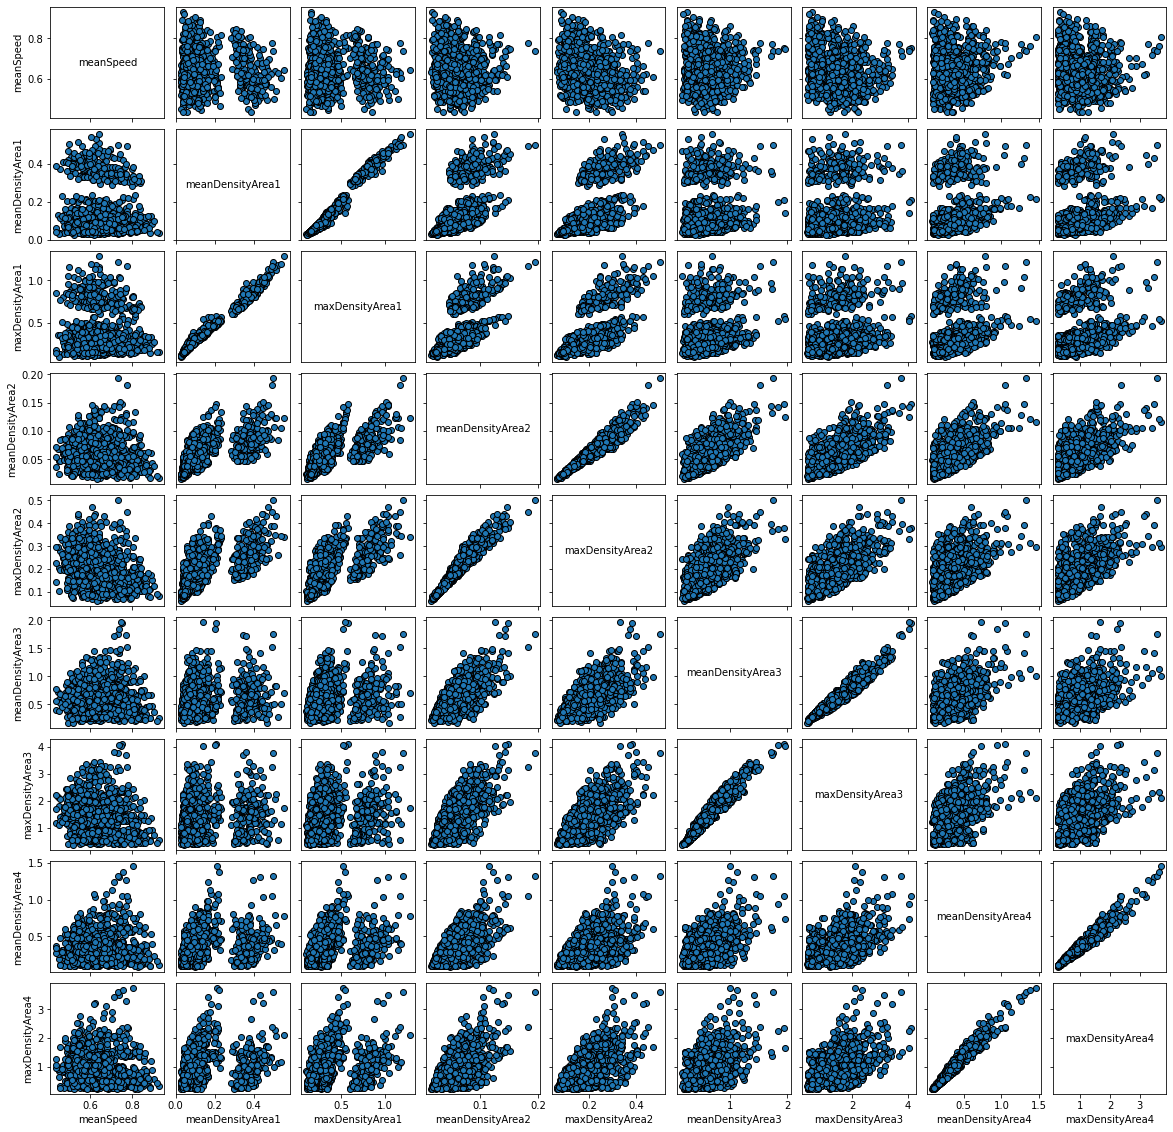

In [10]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(
    experiments,
    results,
)

fig.set_size_inches(20, 20)
plt.show()

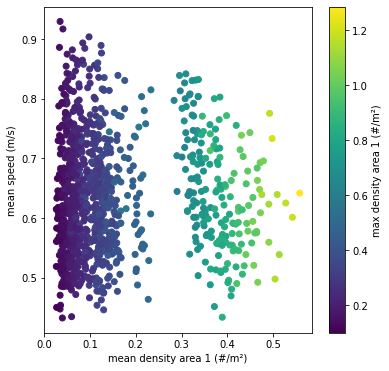

In [11]:
fig, ax = plt.subplots(figsize=(6,6))

sc = ax.scatter(results['meanDensityArea1'], results['meanSpeed'], c=results['maxDensityArea1'])
cbar = plt.colorbar(sc)
cbar.set_label('max density area 1 (#/m²)')
ax.set_xlabel('mean density area 1 (#/m²)')
ax.set_ylabel('mean speed (m/s)')
plt.show()

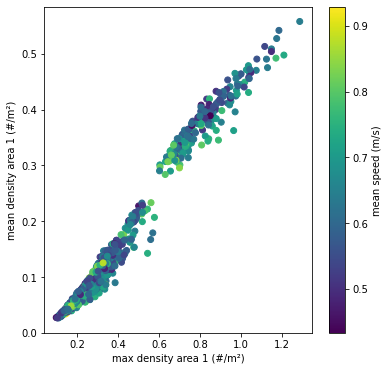

In [12]:
fig, ax = plt.subplots(figsize=(6,6))

sc = ax.scatter(results['maxDensityArea1'], results['meanDensityArea1'], c=results['meanSpeed'])
cbar = plt.colorbar(sc)
cbar.set_label('mean speed (m/s)')
ax.set_xlabel('max density area 1 (#/m²)')
ax.set_ylabel('mean density area 1 (#/m²)')
plt.show()

## Linear regression model

In [13]:
import statsmodels.api as sm

# add constant
X_0 = sm.add_constant(X)

In [14]:
# specify outcome to fit linear regression on
outcome = 'maxDensityArea3'
# outcome = 'meanSpeed'

In [15]:
est = sm.OLS(results_df[outcome], X_0.astype(float)).fit()
print(est.summary())
print(est.params)

                            OLS Regression Results                            
Dep. Variable:        maxDensityArea3   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     984.9
Date:                Wed, 18 May 2022   Prob (F-statistic):               0.00
Time:                        11:39:00   Log-Likelihood:                 94.353
No. Observations:                1000   AIC:                            -168.7
Df Residuals:                     990   BIC:                            -119.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.1838    

## Feature scoring

In [16]:
from ema_workbench.analysis import feature_scoring

# use the extra trees algorithm
fs = feature_scoring.get_feature_scores_all(
    x=X,
    y=results,
    alg='extra trees',
)

/home/tevito/anaconda3/envs/CrowdSim/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/tevito/anaconda3/envs/CrowdSim/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
<frozen importlib._bootstrap>:914: ImportWarning: ShimImporter.find_spec() not found; falling back to find_module()
/home/tevito/anaconda3/envs/CrowdSim/lib/python3.10/site-packages/ema_workbench-2.1.3-py3.10.egg/ema_workbench/analysis/feature_scoring.py:389: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete = complete.append(fs.T, sort=True)
/home/tevito/anaconda3/envs/CrowdSim/lib/python3.10/site-pack

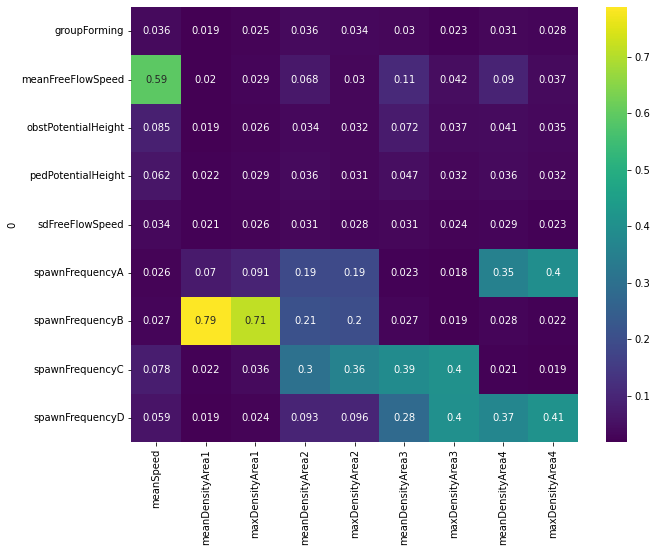

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(fs,
            cmap="viridis",
            annot=True,
            ax=ax)
plt.show()

In [18]:
# repeat for binary clasification
from ema_workbench.analysis import RuleInductionType

x = experiments
y = (
    (results['maxDensityArea1'] >= 1) |
    (results['maxDensityArea2'] >= 1) |
    (results['maxDensityArea3'] >= 1) |
    (results['maxDensityArea4'] >= 1) 
)

fs, alg = feature_scoring.get_ex_feature_scores(
    x, y, mode=RuleInductionType.CLASSIFICATION
)
fs.sort_values(ascending=False, by=1).round(2)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


,1
0,
spawnFrequencyD,0.33
spawnFrequencyC,0.33
spawnFrequencyA,0.13
meanFreeFlowSpeed,0.04
obstPotentialHeight,0.04
pedPotentialHeight,0.04
sdFreeFlowSpeed,0.03
groupForming,0.03
spawnFrequencyB,0.02


## PRIM

In [19]:
x = experiments
y = (
    (results['maxDensityArea1'] >= np.percentile(results['maxDensityArea1'], 80)) |
    (results['maxDensityArea2'] >= np.percentile(results['maxDensityArea2'], 80)) 
)
prim_alg = prim.Prim(
    x,
    y,
    threshold=0.8)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


In [20]:
box1 = prim_alg.find_box()

[MainProcess/INFO] 1000 points remaining, containing 303 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.2, coverage: 0.6600660066006601, density: 1.0 restricted_dimensions: 1


In [21]:
boxes = [box1]

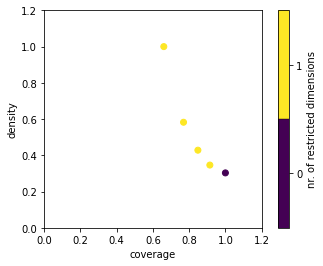

In [22]:
for b in boxes:
    b.show_tradeoff()
    plt.show()

coverage    0.660066
density     1.000000
id          4.000000
mass        0.200000
mean        1.000000
res_dim     1.000000
Name: 4, dtype: float64

                box 4                                      
                  min  max                        qp values
spawnFrequencyB   1.0  1.5  [-1.0, 1.9432366843116483e-104]



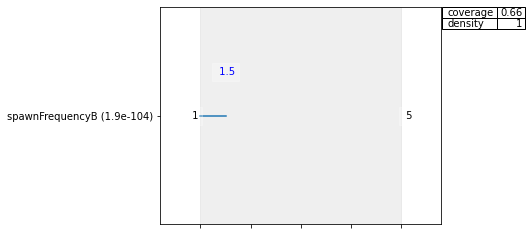

In [23]:
for b in boxes:
    b.inspect()
    b.inspect(style="graph")
    plt.show()

In [24]:
box2 = prim_alg.find_box()

[MainProcess/INFO] 800 points remaining, containing 103 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.703125, returning dump box


In [25]:
x = experiments
y = (
    (results['maxDensityArea1'] >= 1) |
    (results['maxDensityArea2'] >= 1) |
    (results['maxDensityArea3'] >= 1) |
    (results['maxDensityArea4'] >= 1) 
)
prim_alg = prim.Prim(
    x,
    y,
    threshold=0.8)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


In [26]:
box1 = prim_alg.find_box()

[MainProcess/INFO] 1000 points remaining, containing 745 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.4, coverage: 0.5369127516778524, density: 1.0 restricted_dimensions: 1


In [27]:
box2 = prim_alg.find_box()

[MainProcess/INFO] 600 points remaining, containing 345 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.246, coverage: 0.3302013422818792, density: 1.0 restricted_dimensions: 1


In [28]:
box3 = prim_alg.find_box()

[MainProcess/INFO] 354 points remaining, containing 99 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.063, coverage: 0.08456375838926175, density: 1.0 restricted_dimensions: 2


In [29]:
box4 = prim_alg.find_box()

[MainProcess/INFO] 291 points remaining, containing 36 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.5614035087719298, returning dump box


In [30]:
box5 = prim_alg.find_box()

[MainProcess/INFO] no data remaining


In [31]:
boxes = [box1, box2, box3, box4]

In [32]:
prim_alg.boxes_to_dataframe()

box 1              box 2              box 3             \
                       min        max     min        max     min        max   
spawnFrequencyD     1.0000   2.500000  1.0000   5.000000  1.0000   5.000000   
pedPotentialHeight  5.0282  49.986613  5.0282  49.986613  5.0282  47.613528   
spawnFrequencyC     1.0000   5.000000  1.0000   2.500000  1.0000   5.000000   
spawnFrequencyA     1.0000   5.000000  1.0000   5.000000  1.0000   1.500000   

                     box 4             
                       min        max  
spawnFrequencyD     1.0000   5.000000  
pedPotentialHeight  5.0282  49.986613  
spawnFrequencyC     1.0000   5.000000  
spawnFrequencyA     1.0000   5.000000

In [33]:
prim_alg.stats_to_dataframe()

,coverage,density,mass,res_dim
box 1,0.536913,1.000000,0.400,1
box 2,0.330201,1.000000,0.246,1
box 3,0.084564,1.000000,0.063,2
box 4,0.048322,0.123711,0.291,0


In [34]:
prim_alg.stats_to_dataframe()['coverage'].sum()

1.0

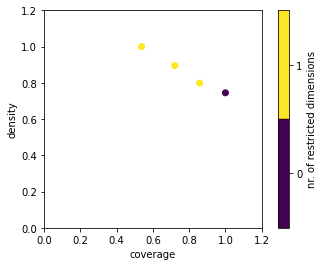

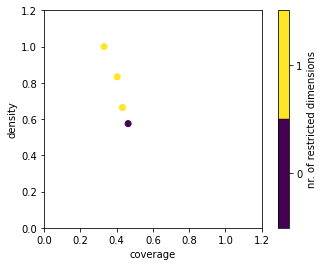

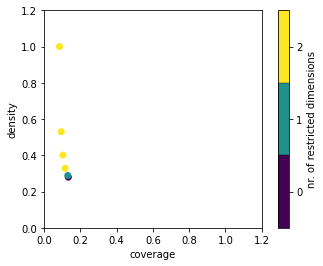

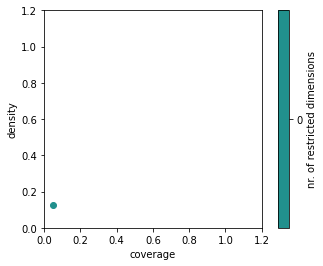

In [35]:
for b in boxes:
    b.show_tradeoff()
    plt.show()

coverage    0.536913
density     1.000000
id          3.000000
mass        0.400000
mean        1.000000
res_dim     1.000000
Name: 3, dtype: float64

                box 3                                   
                  min  max                     qp values
spawnFrequencyD   1.0  2.5  [-1.0, 7.28633440646169e-52]



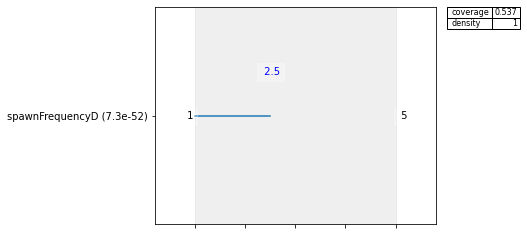

coverage    0.330201
density     1.000000
id          3.000000
mass        0.246000
mean        1.000000
res_dim     1.000000
Name: 3, dtype: float64

                box 3                                    
                  min  max                      qp values
spawnFrequencyC   1.0  2.5  [-1.0, 7.555962496234386e-60]



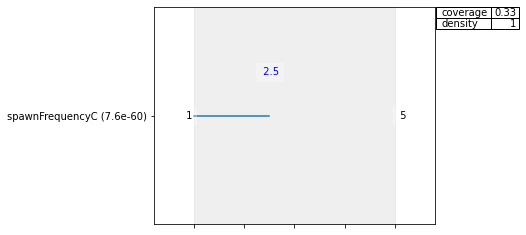

coverage    0.084564
density     1.000000
id          5.000000
mass        0.063000
mean        1.000000
res_dim     2.000000
Name: 5, dtype: float64

                     box 5                                          
                       min        max                      qp values
spawnFrequencyA     1.0000   1.500000  [-1.0, 1.016821646820229e-34]
pedPotentialHeight  5.0282  47.613528      [-1.0, 0.382184904520367]



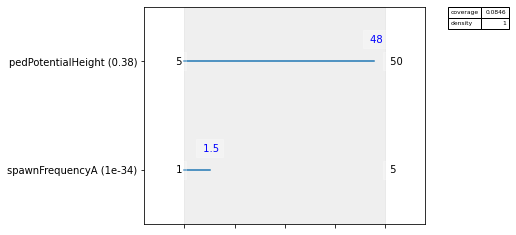

coverage    0.048322
density     0.123711
id          0.000000
mass        0.291000
mean        0.123711
res_dim     0.000000
Name: 0, dtype: float64

Empty DataFrame
Columns: [(box 0, min), (box 0, max), (box 0, qp values)]
Index: []



/home/tevito/anaconda3/envs/CrowdSim/lib/python3.10/site-packages/ema_workbench-2.1.3-py3.10.egg/ema_workbench/analysis/scenario_discovery_util.py:456: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax.set_ylim(top=-0.5, bottom=nr_unc - 0.5)


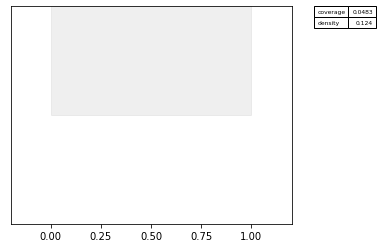

In [36]:
for b in boxes:
    b.inspect()
    b.inspect(style="graph")
    plt.show()